# Periods GAIA, ZTF, PanSTARRS, DES compared to Rubin (Doug)

Overall goal: Compare periods from periodic objects found in other surveys to Rubin ComCam data

Compare periodicity of objects we found with other surveys. We can use this for validation and interesting science.  This is a similar project as project 4, but with swapped starting and ending catalog.

1. Take all objects that you can find in GAIA or ZTF or  PanSTARRS or DES that are in the area that Comcam has covered. Start with one survey first, and expand to other surveys after your completed points below. GAIA has periods provided so it might be a good first choice.
2. Find any object you can for which period is computed. Run LombScargle algorithm on the lightcurves from these non-Rubin surveys. If a period is provided, limit the period search to the range of [catalog_period - 10%, catalog_period + 10%]
3. Find the most interesting objects, and run the same/similar algorithm on Rubin lightcurves. 
4. Compare the results, i.e., are you finding similar numbers in non-Rubin and rubin lightcurve. Are there objects that have changed their period.

**Summary (March 27, 2025): This notebook goes through a few iterations of my attempt at project 5. The first section builds from known periodic objects in Gaia DR3. However, the number of objects in ComCam crossmatched with ZTF's field was pretty small (approx 10). The second section utilizes the VSX catalog to build a healthier set of variable objects (approx 500 in the field). However, in attempting to run periodograms for comcam and ZTF Neven and I discovered that the existing crossmatched products for comcam and ZTF dropped quite a bit of the actual ZTF photometry. Below I have computed periods that are not very well aligned with the truth values, partly due to working with much less data than I should have actually had in ZTF. However, I've spun a bit on just comcam, particularly only trying to match shorter period objects and see a wide range of overlap. There's definitely a tendency towards the extremes of the search region, which I believe signal a failure for periodogram to recover anything real.**

In [40]:
pip install lsdb light_curve

Defaulting to user installation because normal site-packages is not writeable
  Using cached light_curve-0.10.0-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (36 kB)
Using cached light_curve-0.10.0-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (25.7 MB)
Note: you may need to restart the kernel to use updated packages.


In [1]:
import lsdb
from nested_pandas.series.dtype import NestedDtype
import pandas as pd
import dask.dataframe as dd
from astropy.timeseries import LombScargle, LombScargleMultiband
import matplotlib.pyplot as plt
import numpy as np
print(lsdb.__version__)

0.5.0


In [2]:
from dask.distributed import Client

client = Client(n_workers=2, memory_limit="20GB")

## Section 1. Find Set of Truth Variable Objects & Periods From Gaia DR3
Live in separate variability tables: https://gea.esac.esa.int/archive/documentation/GDR2/Gaia_archive/chap_datamodel/sec_dm_variability_tables/

Bulk downloads available here: https://cdn.gea.esac.esa.int/Gaia/gdr3/Variability/

1. Find which variability tables have periods, probably need to pull in a few
2. Load in the relevant tables, hats import them?
3. Cross match these tables to Comcam to get the relevant subset, may need to join through gaia_dr3 first to get ra and dec
4. Do any needed filtering to get towards periods

In [3]:
#gaia_dr3 = lsdb.read_hats('https://data.lsdb.io/hats/gaia_dr3/gaia', margin_cache='https://data.lsdb.io/hats/gaia_dr3/gaia_10arcs', columns="all")
#gaia_dr3#["phot_variable_flag"]
# Columns to use phot_variable_flag

### Build a composite variability table from Gaia DR3 Tables

In [4]:
# Use a universal set of columns
shared_cols = ["Source", "SolID","RA_ICRS", "DE_ICRS", "PF", "P1O"]

#Gaia RRLyrae Catalog - 271779 rows
# https://tapvizier.cds.unistra.fr/adql/?%20I/358/vrrlyr
rrlyr_df = pd.read_csv("/sdf/home/b/brantd/gaia_dr3_rrlyrae_period.csv")[shared_cols]
rrlyr_df["provenance"] = "vari_rrlyr"

# Gaia Variable Cepheid Catalog - 15021 rows
# https://tapvizier.cds.unistra.fr/adql/?%20I/358/scalerts%20I/358/alertsms%20I/358/varisum%20I/358/vclassre%20I/358/vcclassd%20I/358/vagn%20I/358/vcep%20I/358/vceph%20I/358/vcc%20I/358/veb%20I/358/veprv%20I/358/vrvstat%20I/358/vlpv%20I/358/vmicro%20I/358/vmsosc%20I/358/vrm%20I/358/vrmo%20I/358/vrms%20I/358/vpltrans%20I/358/vrrlyr%20I/358/vrrlyrh%20I/358/vst
vcep_df = pd.read_csv("/sdf/home/b/brantd/gaia_dr3_vcep.csv")[shared_cols]
vcep_df["provenance"] = "vari_vcep"

# Compact Companion Candidates - 6306 rows (not enough to be worth adding)

# Eclipsing Binary Candidates - 2184477 rows, but not a clear "period" column
# https://vizier.cds.unistra.fr/viz-bin/VizieR-3?-source=I/358/veb&-out.max=50&-out.form=HTML%20Table&-out.add=_r&-out.add=_RAJ,_DEJ&-sort=_r&-oc.form=sexa


# Look at lightcurves in ZTF and panstarrs with known periods
vari_df = pd.concat([rrlyr_df, vcep_df])
vari_df

Source               SolID     RA_ICRS    DE_ICRS  \
0      1000146253713924352  375316653866487565  103.134722  56.122426   
1      1000148246578725632  375316653866487565  102.900343  56.093749   
...                    ...                 ...         ...        ...   
15019   898874021546560384  375316653866487564  111.608525  37.457896   
15020   958623063948528896  375316653866487564   96.576608  42.698921   

             PF       P1O  provenance  
0           NaN  0.313748  vari_rrlyr  
1           NaN  0.360003  vari_rrlyr  
...         ...       ...         ...  
15019  3.228622       NaN   vari_vcep  
15020  1.669935       NaN   vari_vcep  

[286800 rows x 7 columns]

In [5]:
# Convert to catalog
vari_cat = lsdb.from_dataframe(vari_df, ra_column="RA_ICRS", dec_column="DE_ICRS", catalog_name="gaia_vari")
vari_cat

/sdf/group/rubin/sw/conda/envs/lsst-scipipe-10.0.0/lib/python3.12/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 19.22 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/sdf/group/rubin/sw/conda/envs/lsst-scipipe-10.0.0/lib/python3.12/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 19.22 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


Dask NestedFrame Structure:
                             Source           SolID          RA_ICRS          DE_ICRS               PF              P1O       provenance
npartitions=12                                                                                                                          
0                    int64[pyarrow]  int64[pyarrow]  double[pyarrow]  double[pyarrow]  double[pyarrow]  double[pyarrow]  string[pyarrow]
288230376151711744              ...             ...              ...              ...              ...              ...              ...
...                             ...             ...              ...              ...              ...              ...              ...
3170534137668829184             ...             ...              ...              ...              ...              ...              ...
3458764513820540928             ...             ...              ...              ...              ...              ...              ...
Dask Name: nestedframe, 3 expressions
Expr=MapPartitions(NestedFrame)

(<Figure size 1000x500 with 2 Axes>,
 <WCSAxes: title={'center': 'Catalog pixel density map - gaia_vari'}>)

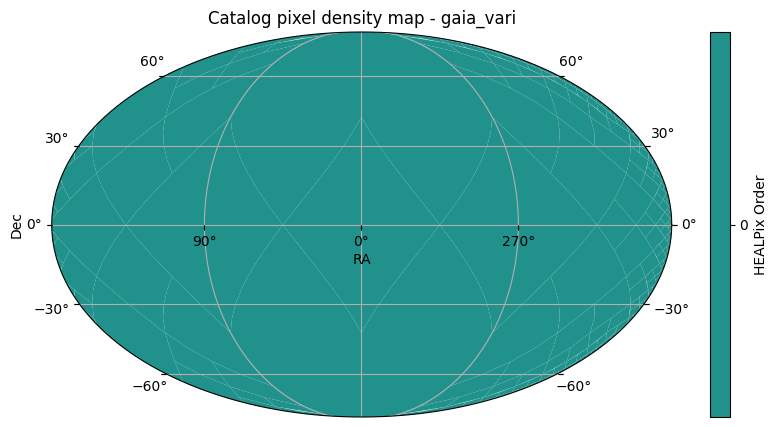

In [6]:
vari_cat.plot_pixels()

### Question: How much total overlap is there between Gaia DR3 and Comcam?

In [6]:
gaia_dr3 = lsdb.read_hats('https://data.lsdb.io/hats/gaia_dr3/gaia', 
                          margin_cache='https://data.lsdb.io/hats/gaia_dr3/gaia_10arcs', 
                          columns=["solution_id","ra", "dec"]) # trimming columns is neccesary for memory management
comcam = lsdb.read_hats("/sdf/data/rubin/shared/lsdb_commissioning/hats/w_2025_11/dia_object_lc",
                        margin_cache='/sdf/data/rubin/shared/lsdb_commissioning/hats/w_2025_11/dia_object_lc_5arcs',
                        columns=["diaObjectId","ra", "dec"])

                    
cc_x_gdr3 = comcam.crossmatch(gaia_dr3)
#len(cc_x_gdr3._ddf) # 327327

### Gaia DR3 Known Periods: ZTF vs Comcam

/sdf/home/b/brantd/.local/lib/python3.12/site-packages/hats/inspection/visualize_catalog.py:309: UserWarning: This plot contains HEALPix pixels smaller than a pixel of the plot. Some values may be lost
  warnings.warn(


(<Figure size 1000x500 with 2 Axes>,
 <WCSAxes: title={'center': 'Catalog pixel density map - dia_object_lc_x_ztf_dr22_x_gaia_vari'}>)

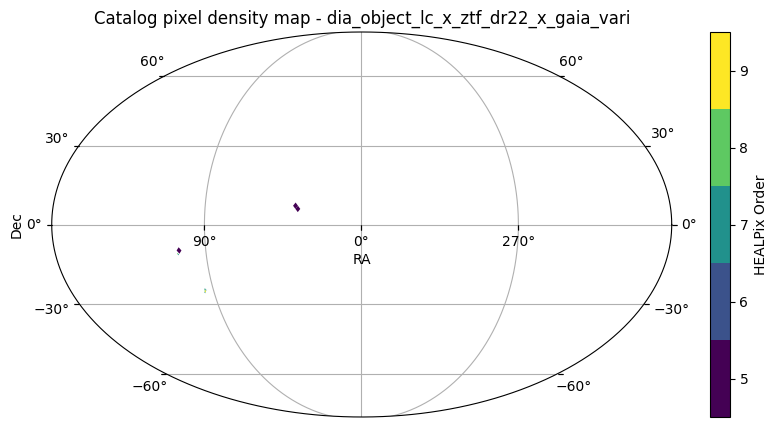

In [8]:
# Load the pre-matched DiaObject & ZTF DR22 Catalog
ztf_cat = lsdb.read_hats('/sdf/data/rubin/shared/lsdb_commissioning/hats/w_2025_11/dia_object_lc_x_ztf_dr22')

# Assign NestedDtypes
ztf_cat._ddf = ztf_cat._ddf.astype({"diaSource":NestedDtype(ztf_cat.dtypes["diaSource"].pyarrow_dtype),
                                    "diaObjectForcedSource":NestedDtype(ztf_cat.dtypes["diaObjectForcedSource"].pyarrow_dtype),
                                    "ztf_lc":NestedDtype(ztf_cat.dtypes["ztf_lc"].pyarrow_dtype)})

# Crossmatch to Gaia DR3 Variability
ztf_vari = ztf_cat.crossmatch(vari_cat)
ztf_vari.plot_pixels()

In [9]:
# Very small -> Go to nested-pandas
vari_ndf = ztf_vari.compute().dropna(subset=["PF_gaia_vari"]).query("nDiaSources_dia_object_lc_x_ztf_dr22>10")
vari_ndf

diaObjectId_dia_object_lc_x_ztf_dr22  \
_healpix_29                                                 
9697289099026113                      4602538081684291611   
1456169048697174952                   2430571608268603427   
1456180540012683497                   2430096619245404295   
1456195138833230598                   2430615588733714511   

                     ra_dia_object_lc_x_ztf_dr22  \
_healpix_29                                        
9697289099026113                       38.601798   
1456169048697174952                    94.997241   
1456180540012683497                    94.790827   
1456195138833230598                    95.013513   

                     dec_dia_object_lc_x_ztf_dr22  \
_healpix_29                                         
9697289099026113                         7.393511   
1456169048697174952                    -24.689506   
1456180540012683497                    -24.681146   
1456195138833230598                    -24.443534   

                     nDiaSources_dia_object_lc_x_ztf_dr22  \
_healpix_29                                                 
9697289099026113                                       20   
1456169048697174952                                   132   
1456180540012683497                                    74   
1456195138833230598                                    11   

                     radecMjdTai_dia_object_lc_x_ztf_dr22  \
_healpix_29                                                 
9697289099026113                             60652.095275   
1456169048697174952                          60656.341488   
1456180540012683497                          60656.341913   
1456195138833230598                          60656.339882   

                     tract_dia_object_lc_x_ztf_dr22  \
_healpix_29                                           
9697289099026113                              10464   
1456169048697174952                            5526   
1456180540012683497                            5525   
1456195138833230598                            5526   

                                    diaSource_dia_object_lc_x_ztf_dr22  \
_healpix_29                                                              
9697289099026113     [{visit: 2024112300216, detector: 5, band: 'r'...   
1456169048697174952  [{visit: 2024111900358, detector: 2, band: 'y'...   
1456180540012683497  [{visit: 2024111900368, detector: 2, band: 'i'...   
1456195138833230598  [{visit: 2024111900364, detector: 2, band: 'y'...   

                        diaObjectForcedSource_dia_object_lc_x_ztf_dr22  \
_healpix_29                                                              
9697289099026113     [{parentObjectId: 0, coord_ra: 38.601798, coor...   
1456169048697174952  [{parentObjectId: 0, coord_ra: 94.997241, coor...   
1456180540012683497  [{parentObjectId: 0, coord_ra: 94.790827, coor...   
1456195138833230598  [{parentObjectId: 0, coord_ra: 95.013513, coor...   

                                       ztf_lc_dia_object_lc_x_ztf_dr22  \
_healpix_29                                                              
9697289099026113     [{objectid_ztf: 452315300000050, filterid_ztf:...   
1456169048697174952  [{objectid_ztf: 258208100005707, filterid_ztf:...   
1456180540012683497  [{objectid_ztf: 258208100015250, filterid_ztf:...   
1456195138833230598  [{objectid_ztf: 258208100001880, filterid_ztf:...   

                        Source_gaia_vari     SolID_gaia_vari  \
_healpix_29                                                    
9697289099026113       19394560480631168  375316653866487565   
1456169048697174952  2912338089863209728  375316653866487565   
1456180540012683497  2912361076526273664  375316653866487565   
1456195138833230598  2912390252242869504  375316653866487565   

                     RA_ICRS_gaia_vari  DE_ICRS_gaia_vari  PF_gaia_vari  \
_healpix_29                                                               
9697289099026113             38.601791           7.393524      0.619628   
145616904869

In [12]:
# Calculate ZTF and Comcam periods, compare to Gaia DR3 "true" periods
def compare_periodograms(true_period, cat1_time, cat1_flux, cat2_time, cat2_flux, label1="cat1", label2="cat2"):
    """a function that computes periodograms in other surveys and in comcam, returns the periods and a diff"""
    #print(true_period, cat1_time, cat1_flux, cat2_time, cat2_flux)
    # define a freq grid to search around the true period/frequency
    true_freq = 1/true_period
    frequency = np.linspace(0.9*true_freq, 1.1*true_freq, 100)

    # cat1_power
    # We offset date, so we still would have <1 second precision
    #cat1_time = np.asarray(cat1_time - 60000, dtype=np.float64)

    # Filter any infinite mags (fluxes here)
    #cat1_time = cat1_time[np.isfinite(cat1_flux)]
    #cat1_flux = cat1_flux[np.isfinite(cat1_flux)]
    cat1_power = LombScargle(cat1_time, cat1_flux).power(frequency)
    cat1_maxpower = np.max(cat1_power)
    cat1_period = 1/frequency[np.argmax(cat1_power)]

    #return {f"{label1}_maxpower": cat1_maxpower, f"{label1}_period": cat1_period}

    # cat2_power
    # We offset date, so we still would have <1 second precision
    #cat2_time = np.asarray(cat2_time - 60000, dtype=np.float32)

    # Filter any infinite mags (fluxes here)
    #cat2_time = cat2_time[np.isfinite(cat2_flux)]
    #cat2_flux = cat2_flux[np.isfinite(cat2_flux)]
    cat2_power = LombScargle(cat2_time, cat2_flux).power(frequency)
    cat2_maxpower = np.max(cat2_power)
    cat2_period = 1/frequency[np.argmax(cat2_power)]

    return {"gaia_period":true_period,
            f"{label1}_maxpower": cat1_maxpower, f"{label1}_period": cat1_period,
            f"{label2}_maxpower": cat2_maxpower, f"{label2}_period": cat2_period}

vari_debug = vari_ndf.rename(columns={"diaObjectForcedSource_dia_object_lc_x_ztf_dr22": "ForcedSource"})
result = vari_debug.reduce(compare_periodograms, 
               "PF_gaia_vari",
               "ztf_lc_dia_object_lc_x_ztf_dr22.hmjd_ztf",
               "ztf_lc_dia_object_lc_x_ztf_dr22.mag_ztf",
               "ForcedSource.midpointMjdTai",
               "ForcedSource.psfMag",
               #cat2_time="diaObjectForcedSource_dia_object_lc_x_ztf_dr22.midpointMjdTai",
               #cat2_flux="diaObjectForcedSource_dia_object_lc_x_ztf_dr22.scienceMag",
               label1="ZTF",
               label2="ForcedSource")
result 

gaia_period  ZTF_maxpower  ZTF_period  \
_healpix_29                                                  
9697289099026113        0.619628      0.419286    0.624040   
1456169048697174952     0.586757      0.262940    0.630716   
1456180540012683497     0.636939      0.493041    0.663060   
1456195138833230598     0.766476      0.573836    0.820336   

                     ForcedSource_maxpower  ForcedSource_period  
_healpix_29                                                      
9697289099026113                       NaN             0.688475  
1456169048697174952               0.175085             0.601958  
1456180540012683497               0.278165             0.585487  
1456195138833230598               0.387914             0.749073

## Section 2. Gather periods from VSX (Variable Sky Index?) catalog

Given not a ton of data from Gaia DR3, use VSX to try to get enough stuff in comcams field

In [3]:
vsx = lsdb.read_hats("https://epyc.astro.washington.edu/~lincc-frameworks/hats_surveys/vsx_2025-03-21/vsx/")
vsx

Dask NestedFrame Structure:
                                OID    Name         VarFlag            RAdeg            DEdeg    Type LimitFlagOnMax           MagMax MaxUncertaintyFlag MaxPassband MinIsAmplitude LimitFlagOnMin           MagMin MinUncertaintyFlag MinPassband            Epoch EpochUncertaintyFlag LimitFlagOnPeriod           Period PeriodUncertaintyFlag SpectralType
npartitions=30                                                                                                                                                                                                                                                                                                                                                
0                    int64[pyarrow]  string  int64[pyarrow]  double[pyarrow]  double[pyarrow]  string         string  double[pyarrow]             string      string         string         string  double[pyarrow]             string      string  double[pyarrow]               string            string  double[pyarrow]                string       string
288230376151711744              ...     ...             ...              ...              ...     ...            ...              ...                ...         ...            ...            ...              ...                ...         ...              ...                  ...               ...              ...                   ...          ...
...                             ...     ...             ...              ...              ...     ...            ...              ...                ...         ...            ...            ...              ...                ...         ...              ...                  ...               ...              ...                   ...          ...
3170534137668829184             ...     ...             ...              ...              ...     ...            ...              ...                ...         ...            ...            ...              ...                ...         ...              ...                  ...               ...              ...                   ...          ...
3458764513820540928             ...     ...             ...              ...              ...     ...            ...              ...                ...         ...            ...            ...              ...                ...         ...              ...                  ...               ...              ...                   ...          ...
Dask Name: nestedframe, 3 expressions
Expr=MapPartitions(NestedFrame)

(<Figure size 1000x500 with 2 Axes>,
 <WCSAxes: title={'center': 'Catalog pixel density map - vsx'}>)

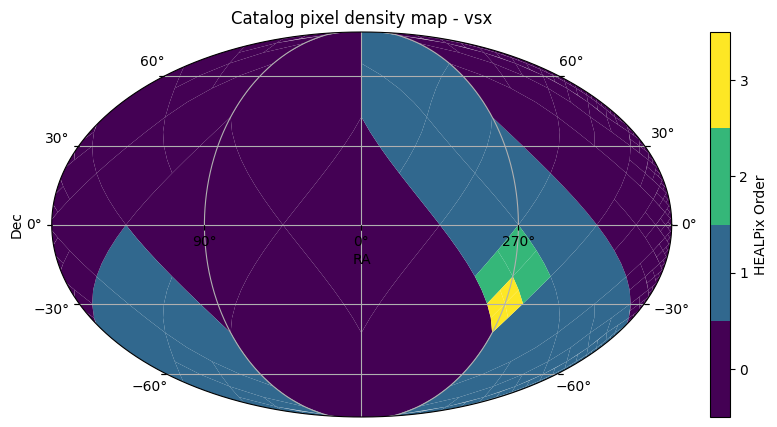

In [4]:
vsx.plot_pixels()

/sdf/home/b/brantd/.local/lib/python3.12/site-packages/lsdb/dask/crossmatch_catalog_data.py:105: RuntimeWarning: Right catalog does not have a margin cache. Results may be incomplete and/or inaccurate.
  warnings.warn(
/sdf/home/b/brantd/.local/lib/python3.12/site-packages/hats/inspection/visualize_catalog.py:309: UserWarning: This plot contains HEALPix pixels smaller than a pixel of the plot. Some values may be lost
  warnings.warn(
/sdf/group/rubin/sw/conda/envs/lsst-scipipe-10.0.0/lib/python3.12/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 13.28 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


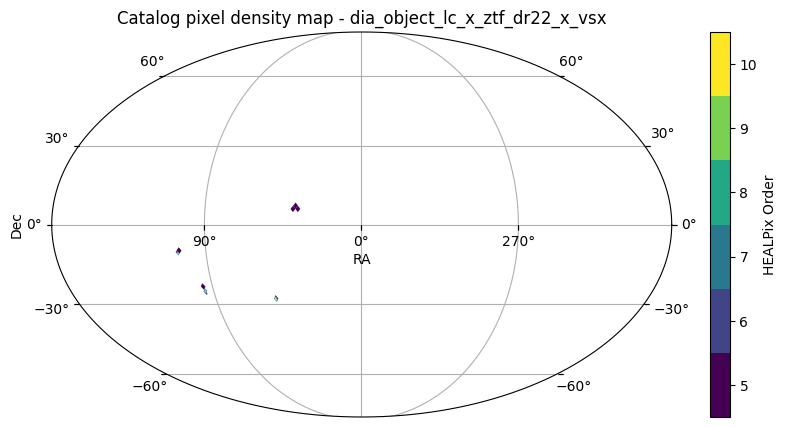

In [122]:
# Load the pre-matched DiaObject & ZTF DR22 Catalog
lc_cat = lsdb.read_hats('/sdf/data/rubin/shared/lsdb_commissioning/hats/w_2025_11/dia_object_lc_x_ztf_dr22')

# Assign NestedDtypes
lc_cat._ddf = lc_cat._ddf.astype({"diaSource":NestedDtype(lc_cat.dtypes["diaSource"].pyarrow_dtype),
                                    "diaObjectForcedSource":NestedDtype(lc_cat.dtypes["diaObjectForcedSource"].pyarrow_dtype),
                                    "ztf_lc":NestedDtype(lc_cat.dtypes["ztf_lc"].pyarrow_dtype)})

# Crossmatch to VSX
lc_vsx = lc_cat.crossmatch(vsx)
lc_vsx.plot_pixels()

lc_ndd = lc_vsx._ddf.persist()

In [123]:
len(lc_vsx._ddf) # 521 objects in the field

/sdf/group/rubin/sw/conda/envs/lsst-scipipe-10.0.0/lib/python3.12/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 13.38 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


521

In [154]:
# lightcurve pre-processing
from nested_pandas.utils import count_nested
vsx_ndf = lc_ndd.compute().dropna(subset=["Period_vsx"])

# Evaluate only for shorter periods
vsx_ndf = vsx_ndf.query("Period_vsx < 1") # less than one day

# filter to r-band
band_filter = True # False because of ztf nobs constraints, but obviously this should be True to get an appropriate answer
if band_filter:
    vsx_ndf = vsx_ndf.query("diaObjectForcedSource_dia_object_lc_x_ztf_dr22.band=='r'").dropna(subset="diaObjectForcedSource_dia_object_lc_x_ztf_dr22")
    vsx_ndf = vsx_ndf.query("ztf_lc_dia_object_lc_x_ztf_dr22.filterid_ztf==2").dropna(subset="ztf_lc_dia_object_lc_x_ztf_dr22")

# filter by nobs counts
nobs_filter=True
nobs_thresh = 20 # only have 20 in ztf
if nobs_filter:
    vsx_ndf = count_nested(vsx_ndf, "diaObjectForcedSource_dia_object_lc_x_ztf_dr22")
    vsx_ndf = vsx_ndf.query(f"n_diaObjectForcedSource_dia_object_lc_x_ztf_dr22 >= {nobs_thresh}")
    
    #vsx_ndf = count_nested(vsx_ndf, "ztf_lc_dia_object_lc_x_ztf_dr22")
    #vsx_ndf = vsx_ndf.query(f"n_ztf_lc_dia_object_lc_x_ztf_dr22 >= {nobs_thresh}")

vsx_ndf

diaObjectId_dia_object_lc_x_ztf_dr22  \
_healpix_29                                                 
1450131236226158541                   2430391288361648356   
1450138420039013725                   2430430870780248311   
1450151548363248049                   2430470453198848100   
1456096346397306339                   2429969075896582211   
1456142101772304735                   2430439666873270647   
1456142321449714931                   2430439666873270933   
1456145241764177783                   2430479249291870271   
1456157018405177472                   2430527627803492825   
1456157750233430985                   2430576006315114506   
1456166869856457081                   2430527627803500377   
1456176865466040321                   2430057036826806408   
1456180540012683497                   2430096619245404295   
1456180634094789968                   2430057036826804401   
1523232618310342418                   3347696247229134464   
1523234586815785067                   3347731431601210230   
1523256506406088309                   3347744625740742907   
1523262008052559497                   3347788606205857734   
1523265775554738074                   3347274034764060897   
1523269806348963349                   3452536879960821167   
1523271956173071169                   3452536879960818167   
1523283478291401193                   3347731431601210815   
1523283701088396075                   3347775412066320837   
1523307661081973412                   3347779810112831768   
1523308814876656195                   3452484103402685839   
1523318475343143677                   3452536879960820845   
2528663615367059103                   2132480811838996481   
2528691262385537335                   2226752938804511645   
2528739081707551906                   2226796919269624932   

                     ra_dia_object_lc_x_ztf_dr22  \
_healpix_29                                        
1450131236226158541                    95.302352   
1450138420039013725                    95.374632   
1450151548363248049                    95.522084   
1456096346397306339                    94.716252   
1456142101772304735                    94.970736   
1456142321449714931                    94.961113   
1456145241764177783                    95.124187   
1456157018405177472                    94.955464   
1456157750233430985                    94.916261   
1456166869856457081                    95.101944   
1456176865466040321                    94.648569   
1456180540012683497                    94.790827   
1456180634094789968                    94.722812   
1523232618310342418                   106.342622   
1523234586815785067                   106.607705   
1523256506406088309                   106.206459   
1523262008052559497                   106.210041   
1523265775554738074                   105.890867   
1523269806348963349                   106.289097   
1523271956173071169                   106.178018   
1523283478291401193                   106.653255   
1523283701088396075                   106.665438   
1523307661081973412                    106.52387   
1523308814876656195                   106.645338   
1523318475343143677                   106.298447   
2528663615367059103                     52.96959   
2528691262385537335                    52.948352   
2528739081707551906                    52.998486   

                     dec_dia_object_lc_x_ztf_dr22  \
_healpix_29                                         
1450131236226158541                    -25.274305   
1450138420039013725                    -25.137054   
1450151548363248049                    -24.994152   
1456096346397306339                    -25.159506   
1456142101772304735                    -25.136428   
1456142321449714931                    -25.093549   
1456145241764177783                    -25.043292   
1456157018405177472                    -24.739525   
1456157750233430985                    -24.696482   
1456166869856457081                    -24.757

In [158]:
# Calculate ZTF and Comcam periods, compare to Gaia DR3 "true" periods
def compare_periodograms(true_period, cat1_time, cat1_flux, cat2_time, cat2_flux, label1="cat1", label2="cat2"):
    """a function that computes periodograms in other surveys and in comcam, returns the periods and a diff"""
    #print(true_period, cat1_time, cat1_flux, cat2_time, cat2_flux)
    # define a freq grid to search around the true period/frequency
    true_freq = 1/true_period
    frequency = np.linspace(0.9*true_freq, 1.1*true_freq, 10000)

    #nyquist_factor=10
    method="slow"
    #samples_per_peak=2
    min_freq = 0.8*true_freq
    max_freq = 1.2*true_freq

    cat1_freq, cat1_power = LombScargle(cat1_time, cat1_flux).autopower(minimum_frequency=min_freq,
                                                                        maximum_frequency=max_freq,
                                                                        method=method)
    cat1_maxpower = np.max(cat1_power)
    cat1_period = 1/cat1_freq[np.argmax(cat1_power)]
    
    cat2_freq, cat2_power = LombScargle(cat2_time, cat2_flux).autopower(minimum_frequency=min_freq,
                                                                        maximum_frequency=max_freq,
                                                                        method=method)
    cat2_maxpower = np.max(cat2_power)
    cat2_period = 1/cat2_freq[np.argmax(cat2_power)]

    return {"gaia_period":true_period,
            f"{label1}_maxpower": cat1_maxpower, f"{label1}_period": cat1_period,
            f"{label2}_maxpower": cat2_maxpower, f"{label2}_period": cat2_period}

vsx_debug = vsx_ndf.rename(columns={"diaObjectForcedSource_dia_object_lc_x_ztf_dr22": "ForcedSource"})
result = vsx_debug.reduce(compare_periodograms, 
               "Period_vsx",
               "ztf_lc_dia_object_lc_x_ztf_dr22.hmjd_ztf",
               "ztf_lc_dia_object_lc_x_ztf_dr22.mag_ztf",
               "ForcedSource.midpointMjdTai",
               "ForcedSource.psfMag",
               #cat2_time="diaObjectForcedSource_dia_object_lc_x_ztf_dr22.midpointMjdTai",
               #cat2_flux="diaObjectForcedSource_dia_object_lc_x_ztf_dr22.scienceMag",
               label1="ZTF",
               label2="ForcedSource")
result

/sdf/group/rubin/sw/conda/envs/lsst-scipipe-10.0.0/lib/python3.12/site-packages/astropy/timeseries/periodograms/lombscargle/core.py:243: RuntimeWarning: divide by zero encountered in scalar divide
  df = 1.0 / baseline / samples_per_peak
/sdf/group/rubin/sw/conda/envs/lsst-scipipe-10.0.0/lib/python3.12/site-packages/astropy/timeseries/periodograms/lombscargle/core.py:257: RuntimeWarning: invalid value encountered in multiply
  return minimum_frequency + df * np.arange(Nf)


gaia_period  ZTF_maxpower  ZTF_period  \
_healpix_29                                                  
1450131236226158541     0.245037      0.899021    0.233584   
1450138420039013725     0.715390      0.373419    0.672153   
1450151548363248049     0.020451      0.002136    0.016394   
1456096346397306339     0.381250      0.123050    0.476562   
1456142101772304735     0.241006      0.479884    0.286470   
1456142321449714931     0.754660      0.754693    0.899334   
1456145241764177783     0.235668      0.814827    0.235664   
1456157018405177472     0.241915      0.692674    0.235403   
1456157750233430985     0.240780      0.981000    0.200686   
1456166869856457081     0.088025      0.410145    0.087843   
1456176865466040321     0.513150      0.644702    0.555128   
1456180540012683497     0.636940      0.561152    0.637103   
1456180634094789968     0.340003      0.484154    0.416701   
1523232618310342418     0.430672      0.716009    0.384915   
1523234586815785067     0.327112           NaN         NaN   
1523256506406088309     0.694834      0.436698    0.735427   
1523262008052559497     0.755238      0.735657    0.696911   
1523265775554738074     0.288852      0.642068    0.324767   
1523269806348963349     0.301453      0.763833    0.322756   
1523271956173071169     0.405215      0.586652    0.370575   
1523283478291401193     0.073845      0.457894    0.080821   
1523283701088396075     0.232663      0.816195    0.234279   
1523307661081973412     0.319343      0.761609    0.335242   
1523308814876656195     0.426020      0.912870    0.371809   
1523318475343143677     0.401145      0.699874    0.419981   
2528663615367059103     0.861960      0.165200    0.879725   
2528691262385537335     0.378966      0.696574    0.427603   
2528739081707551906     0.567950      0.473087    0.601397   

                     ForcedSource_maxpower  ForcedSource_period  
_healpix_29                                                      
1450131236226158541               0.593281             0.304600  
1450138420039013725               0.264908             0.827023  
1450151548363248049               0.267472             0.020089  
1456096346397306339               0.116808             0.339725  
1456142101772304735               0.110569             0.293230  
1456142321449714931               0.129595             0.684960  
1456145241764177783               0.231447             0.276105  
1456157018405177472               0.125085             0.222349  
1456157750233430985               0.713604             0.200578  
1456166869856457081               0.463522             0.074802  
1456176865466040321               0.259281             0.465171  
1456180540012683497               0.953779             0.678376  
1456180634094789968               0.642014             0.420135  
1523232618310342418               0.985999             0.412046  
1523234586815785067               0.973340             0.381558  
1523256506406088309               0.899609             0.729749  
1523262008052559497                    NaN             0.944047  
1523265775554738074               0.827206             0.291836  
1523269806348963349               0.479056             0.330461  
1523271956173071169               0.136116             0.422221  
1523283478291401193               0.597822             0.077965  
1523283701088396075               0.107613             0.221656  
1523307661081973412               0.929129             0.327585  
1523308814876656195               0.472473             0.419903  
1523318475343143677               0.307979             0.371053  
2528663615367059103               0.144938             1.049171  
2528691262385537335                    NaN             0.473708  
2528739081707551906                    NaN             0.709937

In [159]:
comcam_period_pdiff = (result["ForcedSource_period"] - result["gaia_period"])/result["gaia_period"]*100
ztf_period_pdiff = (result["ZTF_period"] - result["gaia_period"])/result["gaia_period"]*100

ztf_comcam_pdiff = (result["ZTF_period"] - result["ForcedSource_period"])/result["ForcedSource_period"]*100
#print(np.array(ztf_period_pdiff))

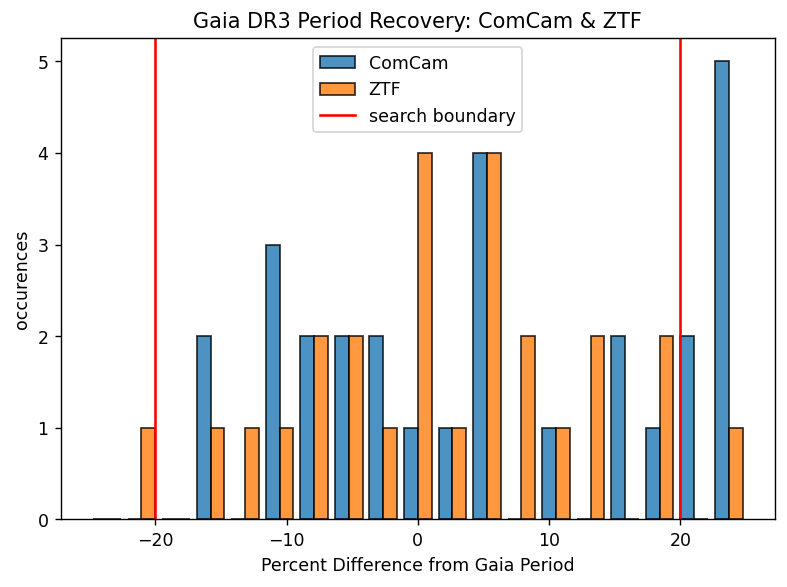

In [168]:
fig = plt.figure(dpi=125)
ax = plt.gca()
bins = np.linspace(-25, 25, 20)
ax.hist([comcam_period_pdiff, ztf_period_pdiff], bins=bins, label=['ComCam', 'ZTF'],ec="k", alpha=0.8)
ax.axvline(-20, color="r", label="search boundary")
ax.axvline(20, color="r")
#ax.hist(comcam_period_pdiff, label="ComCam", ec="k", alpha=0.5, bins=10)
#ax.hist(ztf_period_pdiff, label="ZTF", ec="k", alpha=0.5, bins=10)
ax.legend()
ax.set_title("Gaia DR3 Period Recovery: ComCam & ZTF")
ax.set_ylabel("occurences")
ax.set_xlabel("Percent Difference from Gaia Period")
plt.tight_layout()

In [132]:
# Aside, what is going on with ZTF?
from lsdb.core.search import ConeSearch

ztf = lsdb.read_hats('https://data.lsdb.io/hats/ztf_dr14/ztf_source', search_filter=ConeSearch(ra=37.805427, dec=6.777730, radius_arcsec=2.0))
#ztf_small = ztf.compute()

ztf_cat = lsdb.read_hats('/sdf/data/rubin/shared/lsdb_commissioning/hats/w_2025_11/dia_object_lc_x_ztf_dr22', search_filter=ConeSearch(ra=37.805427, dec=6.777730, radius_arcsec=2.0))

# Assign NestedDtypes
ztf_cat._ddf = ztf_cat._ddf.astype({"diaSource":NestedDtype(ztf_cat.dtypes["diaSource"].pyarrow_dtype),
                                    "diaObjectForcedSource":NestedDtype(ztf_cat.dtypes["diaObjectForcedSource"].pyarrow_dtype),
                                    "ztf_lc":NestedDtype(ztf_cat.dtypes["ztf_lc"].pyarrow_dtype)})

#ztf_x = ztf_cat.compute()


### Debugging: Dig into one lightcurve

In [72]:
vsx_ndf.sort_values(by="nDiaSources_dia_object_lc_x_ztf_dr22", ascending=False)

diaObjectId_dia_object_lc_x_ztf_dr22  \
_healpix_29                                                 
2528741878656607300                   2226832103641710813   
2528743500974760107                   2226836501688221716   
...                                                   ...   
9738944275352509                      4602001520009938068   
2528659483911958051                   2132485209885508340   

                     ra_dia_object_lc_x_ztf_dr22  \
_healpix_29                                        
2528741878656607300                    53.426812   
2528743500974760107                    53.196234   
...                                          ...   
9738944275352509                       37.491249   
2528659483911958051                     52.85467   

                     dec_dia_object_lc_x_ztf_dr22  \
_healpix_29                                         
2528741878656607300                    -27.948312   
2528743500974760107                    -27.922472   
...                                           ...   
9738944275352509                         7.157026   
2528659483911958051                    -28.627211   

                     nDiaSources_dia_object_lc_x_ztf_dr22  \
_healpix_29                                                 
2528741878656607300                                   438   
2528743500974760107                                   429   
...                                                   ...   
9738944275352509                                        1   
2528659483911958051                                     1   

                     radecMjdTai_dia_object_lc_x_ztf_dr22  \
_healpix_29                                                 
2528741878656607300                          60655.249976   
2528743500974760107                           60654.24739   
...                                                   ...   
9738944275352509                              60652.08446   
2528659483911958051                          60645.121267   

                     tract_dia_object_lc_x_ztf_dr22  \
_healpix_29                                           
2528741878656607300                            5063   
2528743500974760107                            5063   
...                                             ...   
9738944275352509                              10463   
2528659483911958051                            4848   

                                    diaSource_dia_object_lc_x_ztf_dr22  \
_healpix_29                                                              
2528741878656607300  [{visit: 2024110800247, detector: 8, band: 'r'...   
2528743500974760107  [{visit: 2024110800245, detector: 1, band: 'i'...   
...                                                                ...   
9738944275352509     [{visit: 2024120700157, detector: 7, band: 'z'...   
2528659483911958051  [{visit: 2024113000173, detector: 8, band: 'u'...   

                        diaObjectForcedSource_dia_object_lc_x_ztf_dr22  \
_healpix_29                                                              
2528741878656607300  [{parentObjectId: 0, coord_ra: 53.426812, coor...   
2528743500974760107  [{parentObjectId: 0, coord_ra: 53.196234, coor...   
...                                                                ...   
9738944275352509     [{parentObjectId: 0, coord_ra: 37.491249, coor...   
2528659483911958051  [{parentObjectId: 0, coord_ra: 52.85467, coord...   

                                       ztf_lc_dia_object_lc_x_ztf_dr22  \
_healpix_29                                                              
2528741878656607300  [{objectid_ztf: 1246105100000267, filterid_ztf...   
2528743500974760107  [{objectid_ztf: 252202300005798, filterid_ztf:...   
...                                                                ...   
9738944275352509     [{objectid_ztf: 452316300008392, filterid_ztf:...   
2528659483911958051  [{objectid_ztf: 1246205200005829, filterid_ztf...   

                     OID_vsx  ... MinPassband_vsx     Epo

20 119


Text(0.5, 1.0, 'Phase Folded Light Curve - Gaia Period: 2.78232')

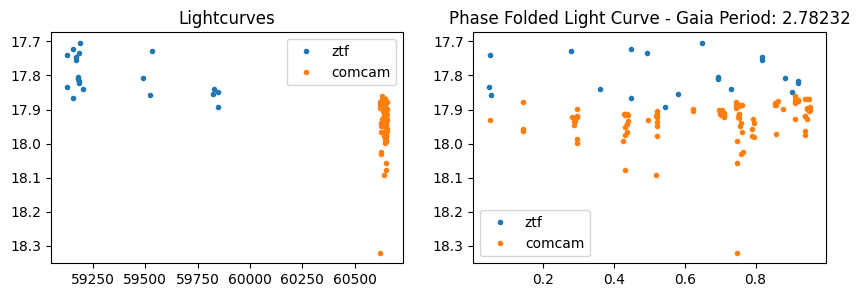

In [75]:
obj = vsx_ndf.loc[2528745994171076527]

ztf_lc = obj["ztf_lc_dia_object_lc_x_ztf_dr22"]
comcam_lc = obj["diaSource_dia_object_lc_x_ztf_dr22"].query("band == 'r'")
print(len(ztf_lc),len(comcam_lc))
#Filter bad photometry
flags = [col for col in comcam_lc.columns if "flag" in col]
comcam_lc = comcam_lc[comcam_lc[flags].sum(axis=1) == 0] # had >
fig, ax = plt.subplots(1,2, figsize=(10,3))
ax[0].plot(ztf_lc["hmjd_ztf"], ztf_lc["mag_ztf"], '.', label="ztf")
ax[0].plot(comcam_lc["midpointMjdTai"], comcam_lc["scienceMag"],'.', label="comcam")
#ax[0].set_ylim(15.9,16.4)
#ax[0].set_xlim(60100,60700)
ax[0].invert_yaxis()
ax[0].set_title("Lightcurves")
ax[0].legend()

#obj['Period_vsx']
#comcam_lc["midpointMjdTai"]%obj['Period_vsx']/obj['Period_vsx']
ax[1].plot(ztf_lc["hmjd_ztf"]%obj['Period_vsx']/obj['Period_vsx'], ztf_lc["mag_ztf"],'.', label="ztf")
ax[1].plot(comcam_lc["midpointMjdTai"]%obj['Period_vsx']/obj['Period_vsx'], comcam_lc["scienceMag"],'.', label="comcam")
ax[1].legend()
ax[1].invert_yaxis()
ax[1].set_title(f"Phase Folded Light Curve - Gaia Period: {obj['Period_vsx']}")

In [121]:
result.loc[2528745994171076527]

gaia_period              2.782320
ZTF_maxpower             0.363260
ZTF_period               2.754604
ForcedSource_maxpower         NaN
ForcedSource_period      3.091467
Name: 2528745994171076527, dtype: float64

## [Maybe Someday] VSX vs Comcam_x_PS1

Todo: Need to grab sources and join them in as this only has ps1 objects

/sdf/home/b/brantd/.local/lib/python3.12/site-packages/lsdb/dask/crossmatch_catalog_data.py:105: RuntimeWarning: Right catalog does not have a margin cache. Results may be incomplete and/or inaccurate.
  warnings.warn(
/sdf/home/b/brantd/.local/lib/python3.12/site-packages/hats/inspection/visualize_catalog.py:309: UserWarning: This plot contains HEALPix pixels smaller than a pixel of the plot. Some values may be lost
  warnings.warn(


(<Figure size 1000x500 with 2 Axes>,
 <WCSAxes: title={'center': 'Catalog pixel density map - dia_object_lc_x_ps1_x_vsx'}>)

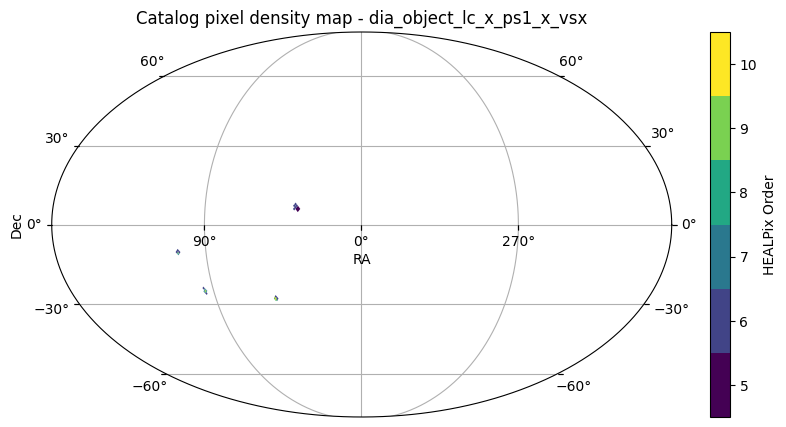

In [118]:
ps1_cat = lsdb.read_hats('/sdf/data/rubin/shared/lsdb_commissioning/hats/w_2025_11/dia_object_lc_x_ps1')

# Assign NestedDtypes
ps1_cat._ddf = ps1_cat._ddf.astype({"diaSource":NestedDtype(ps1_cat.dtypes["diaSource"].pyarrow_dtype),
                                    "diaObjectForcedSource":NestedDtype(ps1_cat.dtypes["diaObjectForcedSource"].pyarrow_dtype)})

# Crossmatch to VSX
lc_vsx = ps1_cat.crossmatch(vsx)
lc_vsx.plot_pixels()

In [119]:
ps1_cat.head(2)

diaObjectId         ra       dec  nDiaSources  \
_healpix_29                                                               
9195067126109851  4601676064568115201  38.086344  6.026142            1   
9195294986354169  4602155451637825582  38.163973  6.008073            1   

                   radecMjdTai  tract  \
_healpix_29                             
9195067126109851  60641.062221  10463   
9195294986354169  60642.055203  10464   

                                                          diaSource  \
_healpix_29                                                           
9195067126109851  [{visit: 2024112600118, detector: 8, band: 'g'...   
9195294986354169  [{visit: 2024112700091, detector: 8, band: 'g'...   

                                              diaObjectForcedSource  \
_healpix_29                                                           
9195067126109851  [{parentObjectId: 0, coord_ra: 38.086344, coor...   
9195294986354169  [{parentObjectId: 0, coord_ra: 38.163973, coor...   

                            objName_ps1           objNameHMS_ps1  ...  \
_healpix_29                                                       ...   
9195067126109851  PSO J038.0863+06.0261  PSX J023220.71+060134.0  ...   
9195294986354169  PSO J038.1640+06.0081  PSX J023239.35+060029.0  ...   

                 yMeanKronMagNpt_ps1 yMeanApMag_ps1 yMeanApMagErr_ps1  \
_healpix_29                                                             
9195067126109851                   4        19.6196          0.125987   
9195294986354169                  13        15.0206          0.002353   

                 yMeanApMagStd_ps1  yMeanApMagNpt_ps1  yFlags_ps1  \
_healpix_29                                                         
9195067126109851          0.306786                  4    16892216   
9195294986354169          0.010821                 13      115000   

                  lsst_ztf_sep  Norder  Dir  Npix  
_healpix_29                                        
9195067126109851      0.097684       6    0   130  
9195294986354169      0.015994       6    0   130  

[2 rows x 143 columns]

## [OLD] Calculate LombScargle Periods For Non-Rubin Lightcurves
ZTF to start, PS1, DESC after

### ZTF

/sdf/home/b/brantd/.local/lib/python3.12/site-packages/hats/inspection/visualize_catalog.py:309: UserWarning: This plot contains HEALPix pixels smaller than a pixel of the plot. Some values may be lost
  warnings.warn(


53011

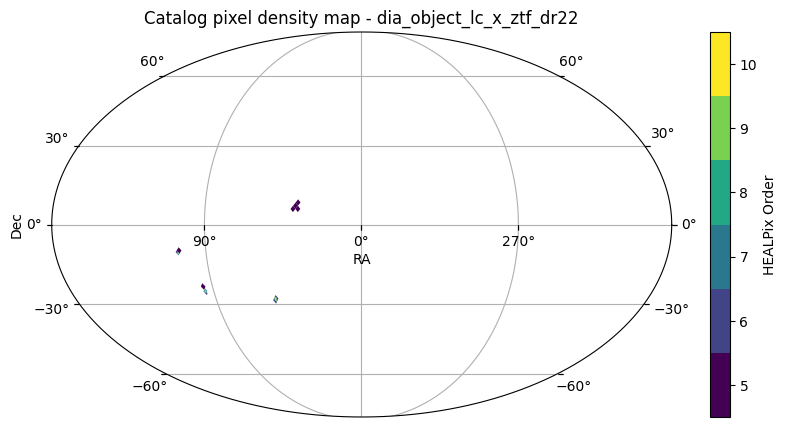

In [7]:
ztf_cat = lsdb.read_hats('/sdf/data/rubin/shared/lsdb_commissioning/hats/w_2025_11/dia_object_lc_x_ztf_dr22')

# Assign NestedDtypes
ztf_cat._ddf = ztf_cat._ddf.astype({"diaSource":NestedDtype(ztf_cat.dtypes["diaSource"].pyarrow_dtype),
                                    "diaObjectForcedSource":NestedDtype(ztf_cat.dtypes["diaObjectForcedSource"].pyarrow_dtype),
                                    "ztf_lc":NestedDtype(ztf_cat.dtypes["ztf_lc"].pyarrow_dtype)})


ztf_cat.plot_pixels()
len(ztf_cat)

/sdf/home/b/brantd/.local/lib/python3.12/site-packages/hats/inspection/visualize_catalog.py:309: UserWarning: This plot contains HEALPix pixels smaller than a pixel of the plot. Some values may be lost
  warnings.warn(


(<Figure size 1000x500 with 2 Axes>,
 <WCSAxes: title={'center': 'Catalog pixel density map - dia_object_lc_x_ztf_dr22_x_gaia_vari'}>)

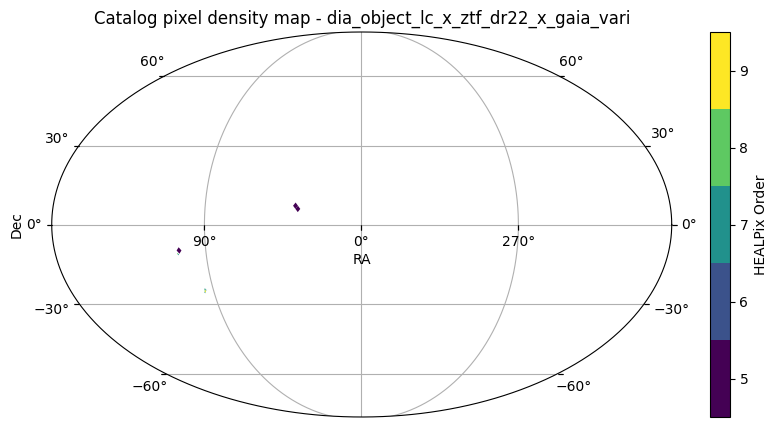

In [8]:
ztf_vari = ztf_cat.crossmatch(vari_cat)
ztf_vari.plot_pixels()

In [201]:
# Very small -> Go to nested-pandas
vari_ndf = ztf_vari.compute().dropna(subset=["PF_gaia_vari"]).query("nDiaSources_dia_object_lc_x_ztf_dr22>10")
vari_ndf

diaObjectId_dia_object_lc_x_ztf_dr22  \
_healpix_29                                                 
9697289099026113                      4602538081684291611   
1456169048697174952                   2430571608268603427   
1456180540012683497                   2430096619245404295   
1456195138833230598                   2430615588733714511   

                     ra_dia_object_lc_x_ztf_dr22  \
_healpix_29                                        
9697289099026113                       38.601798   
1456169048697174952                    94.997241   
1456180540012683497                    94.790827   
1456195138833230598                    95.013513   

                     dec_dia_object_lc_x_ztf_dr22  \
_healpix_29                                         
9697289099026113                         7.393511   
1456169048697174952                    -24.689506   
1456180540012683497                    -24.681146   
1456195138833230598                    -24.443534   

                     nDiaSources_dia_object_lc_x_ztf_dr22  \
_healpix_29                                                 
9697289099026113                                       20   
1456169048697174952                                   132   
1456180540012683497                                    74   
1456195138833230598                                    11   

                     radecMjdTai_dia_object_lc_x_ztf_dr22  \
_healpix_29                                                 
9697289099026113                             60652.095275   
1456169048697174952                          60656.341488   
1456180540012683497                          60656.341913   
1456195138833230598                          60656.339882   

                     tract_dia_object_lc_x_ztf_dr22  \
_healpix_29                                           
9697289099026113                              10464   
1456169048697174952                            5526   
1456180540012683497                            5525   
1456195138833230598                            5526   

                                    diaSource_dia_object_lc_x_ztf_dr22  \
_healpix_29                                                              
9697289099026113     [{visit: 2024112300216, detector: 5, band: 'r'...   
1456169048697174952  [{visit: 2024111900358, detector: 2, band: 'y'...   
1456180540012683497  [{visit: 2024111900368, detector: 2, band: 'i'...   
1456195138833230598  [{visit: 2024111900364, detector: 2, band: 'y'...   

                        diaObjectForcedSource_dia_object_lc_x_ztf_dr22  \
_healpix_29                                                              
9697289099026113     [{parentObjectId: 0, coord_ra: 38.601798, coor...   
1456169048697174952  [{parentObjectId: 0, coord_ra: 94.997241, coor...   
1456180540012683497  [{parentObjectId: 0, coord_ra: 94.790827, coor...   
1456195138833230598  [{parentObjectId: 0, coord_ra: 95.013513, coor...   

                                       ztf_lc_dia_object_lc_x_ztf_dr22  \
_healpix_29                                                              
9697289099026113     [{objectid_ztf: 452315300000050, filterid_ztf:...   
1456169048697174952  [{objectid_ztf: 258208100005707, filterid_ztf:...   
1456180540012683497  [{objectid_ztf: 258208100015250, filterid_ztf:...   
1456195138833230598  [{objectid_ztf: 258208100001880, filterid_ztf:...   

                        Source_gaia_vari     SolID_gaia_vari  \
_healpix_29                                                    
9697289099026113       19394560480631168  375316653866487565   
1456169048697174952  2912338089863209728  375316653866487565   
1456180540012683497  2912361076526273664  375316653866487565   
1456195138833230598  2912390252242869504  375316653866487565   

                     RA_ICRS_gaia_vari  DE_ICRS_gaia_vari  PF_gaia_vari  \
_healpix_29                                                               
9697289099026113             38.601791           7.393524      0.619628   
145616904869

In [114]:
comcam_lc.columns

Index(['parentObjectId', 'coord_ra', 'coord_dec', 'visit', 'detector', 'band',
       'psfFlux', 'psfFluxErr', 'psfFlux_flag', 'psfDiffFlux',
       'psfDiffFluxErr', 'psfDiffFlux_flag', 'localPhotoCalib',
       'localPhotoCalib_flag', 'localPhotoCalibErr', 'localWcs_flag',
       'localWcs_CDMatrix_2_1', 'localWcs_CDMatrix_1_1',
       'localWcs_CDMatrix_1_2', 'localWcs_CDMatrix_2_2',
       'localBackground_instFlux', 'localBackground_instFluxErr',
       'pixelFlags_edge', 'pixelFlags_interpolated', 'pixelFlags_saturated',
       'pixelFlags_cr', 'pixelFlags_bad', 'pixelFlags_suspect',
       'pixelFlags_interpolatedCenter', 'pixelFlags_saturatedCenter',
       'pixelFlags_crCenter', 'pixelFlags_suspectCenter', 'invalidPsfFlag',
       'tract', 'patch', 'forcedSourceOnDiaObjectId', 'psfMag', 'psfMagErr',
       'midpointMjdTai'],
      dtype='object')

In [200]:
#comcam_lc

In [139]:
vari_ndf

diaObjectId_dia_object_lc_x_ztf_dr22  \
_healpix_29                                                 
9697289099026113                      4602538081684291611   
1456169048697174952                   2430571608268603427   
1456180540012683497                   2430096619245404295   
1456195138833230598                   2430615588733714511   

                     ra_dia_object_lc_x_ztf_dr22  \
_healpix_29                                        
9697289099026113                       38.601798   
1456169048697174952                    94.997241   
1456180540012683497                    94.790827   
1456195138833230598                    95.013513   

                     dec_dia_object_lc_x_ztf_dr22  \
_healpix_29                                         
9697289099026113                         7.393511   
1456169048697174952                    -24.689506   
1456180540012683497                    -24.681146   
1456195138833230598                    -24.443534   

                     nDiaSources_dia_object_lc_x_ztf_dr22  \
_healpix_29                                                 
9697289099026113                                       20   
1456169048697174952                                   132   
1456180540012683497                                    74   
1456195138833230598                                    11   

                     radecMjdTai_dia_object_lc_x_ztf_dr22  \
_healpix_29                                                 
9697289099026113                             60652.095275   
1456169048697174952                          60656.341488   
1456180540012683497                          60656.341913   
1456195138833230598                          60656.339882   

                     tract_dia_object_lc_x_ztf_dr22  \
_healpix_29                                           
9697289099026113                              10464   
1456169048697174952                            5526   
1456180540012683497                            5525   
1456195138833230598                            5526   

                                    diaSource_dia_object_lc_x_ztf_dr22  \
_healpix_29                                                              
9697289099026113     [{visit: 2024112300216, detector: 5, band: 'r'...   
1456169048697174952  [{visit: 2024111900358, detector: 2, band: 'y'...   
1456180540012683497  [{visit: 2024111900368, detector: 2, band: 'i'...   
1456195138833230598  [{visit: 2024111900364, detector: 2, band: 'y'...   

                        diaObjectForcedSource_dia_object_lc_x_ztf_dr22  \
_healpix_29                                                              
9697289099026113     [{parentObjectId: 0, coord_ra: 38.601798, coor...   
1456169048697174952  [{parentObjectId: 0, coord_ra: 94.997241, coor...   
1456180540012683497  [{parentObjectId: 0, coord_ra: 94.790827, coor...   
1456195138833230598  [{parentObjectId: 0, coord_ra: 95.013513, coor...   

                                       ztf_lc_dia_object_lc_x_ztf_dr22  \
_healpix_29                                                              
9697289099026113     [{objectid_ztf: 452315300000050, filterid_ztf:...   
1456169048697174952  [{objectid_ztf: 258208100005707, filterid_ztf:...   
1456180540012683497  [{objectid_ztf: 258208100015250, filterid_ztf:...   
1456195138833230598  [{objectid_ztf: 258208100001880, filterid_ztf:...   

                        Source_gaia_vari     SolID_gaia_vari  \
_healpix_29                                                    
9697289099026113       19394560480631168  375316653866487565   
1456169048697174952  2912338089863209728  375316653866487565   
1456180540012683497  2912361076526273664  375316653866487565   
1456195138833230598  2912390252242869504  375316653866487565   

                     RA_ICRS_gaia_vari  DE_ICRS_gaia_vari  PF_gaia_vari  \
_healpix_29                                                               
9697289099026113             38.601791           7.393524      0.619628   
145616904869

33


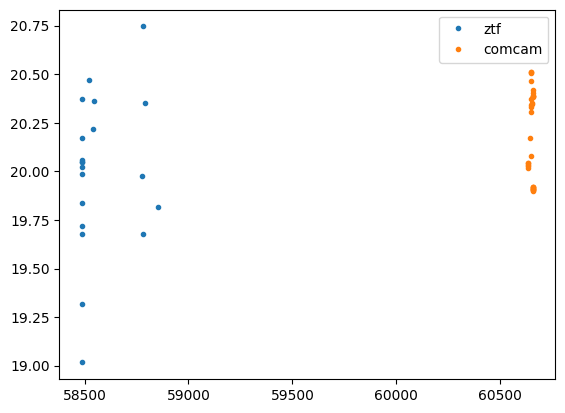

In [145]:
import matplotlib.pyplot as plt
pd.set_option("display.max_rows", 100)

obj = vari_ndf.loc[1456180540012683497]

ztf_lc = obj["ztf_lc_dia_object_lc_x_ztf_dr22"]
comcam_lc = obj["diaSource_dia_object_lc_x_ztf_dr22"].query("band == 'r'")
print(len(comcam_lc))
#Filter bad photometry
flags = [col for col in comcam_lc.columns if "flag" in col]
comcam_lc = comcam_lc[comcam_lc[flags].sum(axis=1) == 0] # had >

plt.plot(ztf_lc["hmjd_ztf"], ztf_lc["mag_ztf"], '.', label="ztf")
plt.plot(comcam_lc["midpointMjdTai"], comcam_lc["scienceMag"],'.', label="comcam")
plt.legend()
#plt.plot(ztf_lc[""])

In [106]:
ztf_lc.columns

Index(['objectid_ztf', 'filterid_ztf', 'fieldid_ztf', 'rcid_ztf', 'objra_ztf',
       'objdec_ztf', 'nepochs_ztf', 'hmjd_ztf', 'mag_ztf', 'magerr_ztf',
       'clrcoeff_ztf', 'catflags_ztf', 'lsst_ztf_sep'],
      dtype='object')

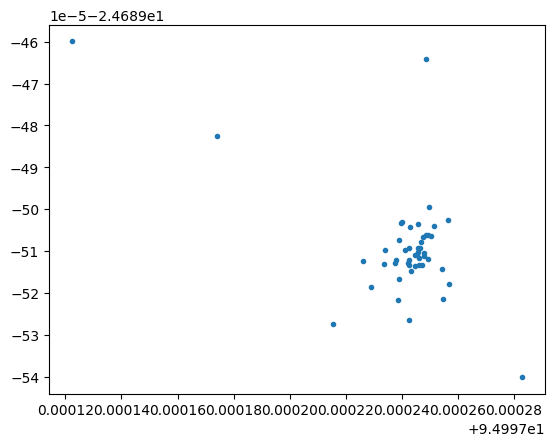

In [107]:
plt.plot(comcam_lc["ra"], comcam_lc["dec"],'.', label="comcam")
#plt.plot(ztf_lc["ra"], ztf_lc["dec"],'.', label="ZTF")

In [86]:
len(comcam_lc[comcam_lc[flags].sum(axis=1) == 0])

48

In [211]:
#comcam_lc[comcam_lc[flags].sum(axis=1) == 0].sort_values("scienceMag", ascending=False)

In [ ]:
comcam_lc[comcam_lc[flags].sum(axis=1) == 0]

In [96]:
comcam_lc[flags+["band"]].query("band == 'r'").columns

Index(['centroid_flag', 'apFlux_flag', 'apFlux_flag_apertureTruncated',
       'psfFlux_flag', 'psfFlux_flag_noGoodPixels', 'psfFlux_flag_edge',
       'forced_PsfFlux_flag', 'forced_PsfFlux_flag_noGoodPixels',
       'forced_PsfFlux_flag_edge', 'shape_flag', 'shape_flag_no_pixels',
       'shape_flag_not_contained', 'shape_flag_parent_source',
       'trail_flag_edge', 'band'],
      dtype='object')

In [ ]:
plt.plot(vari_ndf["diaSource_dia_object_lc_x_ztf_dr22"]

In [10]:
#rrlyr_ndf["ztf_lc_dia_object_lc_x_ztf_dr22"].nest.fields

In [21]:
import light_curve as licu
import numpy as np

extractor = licu.Extractor(
    licu.Periodogram(
        peaks=1,
        nyquist=0.5, # this seems to hang the run
        max_freq_factor=20, # Currently 1.0 for fast runs, will raise for more interesting graphs later
        fast=False,
    ),  # Would give two features: peak period and signa-to-noise ratio of the peak
)


# light-curve requires all arrays to be the same dtype.
# It also requires the time array to be ordered and to have no duplicates.
def extract_features(mjd, mag, **kwargs):
    # We offset date, so we still would have <1 second precision
    t = np.asarray(mjd - 60000, dtype=np.float32)

    # Filter any infinite mags (fluxes here)
    t = t[np.isfinite(mag)]
    mag = mag[np.isfinite(mag)]

    _, sort_index = np.unique(t, return_index=True)
    features = extractor(
        t[sort_index],
        mag[sort_index],
        **kwargs,
    )
    # Return the features as a dictionary
    return dict(zip(extractor.names, features))


features = vari_ndf.reduce(
    extract_features,
    "ztf_lc_dia_object_lc_x_ztf_dr22.hmjd_ztf",
    "ztf_lc_dia_object_lc_x_ztf_dr22.mag_ztf",
    #meta={name: np.float32 for name in extractor.names},
)


vari_features_ztf = vari_ndf.join(features)[["PF_gaia_vari","period_0", "period_s_to_n_0"]]
vari_features_ztf

PF_gaia_vari  period_0  period_s_to_n_0
_healpix_29                                                 
9697289099026113         0.619628  0.620668         6.508679
1456169048697174952      0.586757  1.327931         4.420923
1456180540012683497      0.636939  0.042301         7.991445
1456195138833230598      0.766476  3.313207         6.809919

### Panstarrs

In [12]:
ps1 = lsdb.read_hats('/sdf/data/rubin/shared/lsdb_commissioning/hats/w_2025_11/dia_object_lc_x_ps1')
ps1

Dask NestedFrame Structure:
                        diaObjectId               ra              dec     nDiaSources      radecMjdTai           tract                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      diaSource                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

## [OLD] Calculate LombScargle Periods for matched Rubin Lightcurves
Plot differences in periods per object

In [13]:
#rrlyr_ndf["diaSource_dia_object_lc_x_ztf_dr22"].nest.fields

In [23]:
import light_curve as licu
import numpy as np

extractor = licu.Extractor(
    licu.Periodogram(
        peaks=1,
        #nyquist=0.5, # this seems to hang the run
        max_freq_factor=30, # Currently 1.0 for fast runs, will raise for more interesting graphs later
        fast=False,
    ),  # Would give two features: peak period and signa-to-noise ratio of the peak
)


# light-curve requires all arrays to be the same dtype.
# It also requires the time array to be ordered and to have no duplicates.
def extract_features(mjd, mag, **kwargs):
    # We offset date, so we still would have <1 second precision
    t = np.asarray(mjd - 60000, dtype=np.float64)

    # Filter any infinite mags (fluxes here)
    t = t[np.isfinite(mag)]
    mag = mag[np.isfinite(mag)]

    _, sort_index = np.unique(t, return_index=True)
    features = extractor(
        t[sort_index],
        mag[sort_index],
        **kwargs,
    )
    # Return the features as a dictionary
    return dict(zip(extractor.names, features))


features = vari_ndf.reduce(
    extract_features,
    "diaSource_dia_object_lc_x_ztf_dr22.midpointMjdTai",
    "diaSource_dia_object_lc_x_ztf_dr22.psfMag",
    #meta={name: np.float32 for name in extractor.names},
)

vari_features_comcam = vari_ndf.join(features)[["PF_gaia_vari","period_0", "period_s_to_n_0"]]
vari_features_comcam

PF_gaia_vari  period_0  period_s_to_n_0
_healpix_29                                                 
9697289099026113         0.619628  0.983600         1.563312
1456169048697174952      0.586757  0.031894         5.501743
1456180540012683497      0.636939  0.201770         1.964900
1456195138833230598      0.766476  0.397988         2.383210